In [61]:
import requests
import json
import rasterio as rio
import rioxarray as rxr
import pandas as pd

import matplotlib.pyplot as plt
import earthpy.plot as ep
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


import plotly.graph_objects as go

import numpy as np
import zipfile


In [62]:
street='Zeedijk'
number='451'
post='8670'

In [63]:
polygone=[]

In [64]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [65]:
house_info(street, number, post)

Address found: Id1 is 1945410
Building units found: Id2 is 15857401
Building found: Id3 is 15856569


In [66]:
x=polygone[0][0][0]
y=polygone[0][0][1]


In [67]:
dtm_df= pd.read_csv('dtm_info.csv')
dtm_df.set_index('file', inplace=True)

In [68]:
dsm_df= pd.read_csv('dsm_info.csv')
dsm_df.set_index('file', inplace=True)

In [69]:
file_dsm_selected = dsm_df.loc[
    (x < dsm_df.xmax) & (x > dsm_df.xmin) & (y < dsm_df.ymax) & (y > dsm_df.ymin)
]

dsm_selected = file_dsm_selected.index.format()[0]


In [70]:
file_dtm_selected = dtm_df.loc[
    (x < dtm_df.xmax) & (x > dtm_df.xmin) & (y < dtm_df.ymax) & (y > dtm_df.ymin)
]
dtm_selected = file_dtm_selected.index.format()[0]

In [71]:
post_link_dtm= dtm_selected.split('.')[0]+'.zip'
post_link_dsm= dsm_selected.split('.')[0]+'.zip'

In [72]:
base_url_dtm="https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/"
base_url_dsm="https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/"

In [73]:
url_dtm=base_url_dtm+post_link_dtm
url_dsm=base_url_dsm+post_link_dsm

In [74]:
def download_dtm(url_dtm):
    filename=url_dtm.split('/')[-1]
    r=requests.get(url_dtm, stream=True)
    if r.ok:
        with open(filename, 'wb') as file:
            for chunk in r.iter_content(1024*100):
                file.write(chunk)
    else:
        print('error')

In [75]:
def download_dsm(url_dsm):
    filename=url_dsm.split('/')[-1]
    r=requests.get(url_dsm, stream=True)
    if r.ok:
        with open(filename, 'wb') as file:
            for chunk in r.iter_content(1024*100):
                file.write(chunk)
    else:
        print('error')

In [76]:
download_dtm(url_dtm)
download_dsm(url_dsm)

In [77]:
targetdtm=url_dtm.split('/')[-1]
targetdsm=url_dsm.split('/')[-1]

In [78]:
handledtm = zipfile.ZipFile(targetdtm)
handledsm = zipfile.ZipFile(targetdsm)

In [79]:
handledtm.extract('GeoTIFF/'+dtm_selected)
handledsm.extract('GeoTIFF/'+dsm_selected)

'c:\\Users\\Daniel\\Documents\\BeCode_Projects\\houses3d\\GeoTIFF\\DHMVIIDSMRAS1m_k11.tif'

In [80]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': polygone
    }
]

In [81]:
read_dsm = rxr.open_rasterio("GeoTIFF/" + dsm_selected).rio.clip(geometries, from_disk=True)
read_dtm = rxr.open_rasterio("GeoTIFF/" + dtm_selected).rio.clip(geometries, from_disk=True)

In [82]:
canopy =  read_dsm - read_dtm

In [83]:
canopy.rio.to_raster("clipped.tif")

In [84]:
with rio.open("clipped.tif") as img:
    chm = img.read(1)

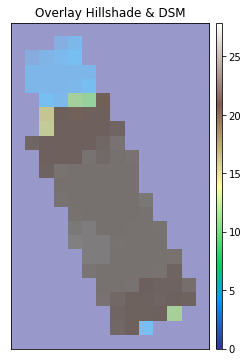

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm, ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm, cmap="Greys", alpha=0.5)
plt.show()


In [86]:

z = chm
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [87]:
print('Altitude:',np.amax(z),'m')
print('Coordinates:',polygone[0][0][0],',',polygone[0][0][1])

Altitude: 27.895977 m
Coordinates: 31264.32709718496 , 203900.1499035433
